In [1]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')
from matplotlib import pyplot

In [2]:
df = pd.read_csv('Admission_Predict_Ver1.1.csv')

In [3]:
dg = df.head(10).T

In [4]:
dg

,0,1,2,3,4,5,6,7,8,9
Serial No.,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.0,10.00
GRE Score,337.00,324.00,316.00,322.00,314.00,330.00,321.00,308.00,302.0,323.00
TOEFL Score,118.00,107.00,104.00,110.00,103.00,115.00,109.00,101.00,102.0,108.00
University Rating,4.00,4.00,3.00,3.00,2.00,5.00,3.00,2.00,1.0,3.00
SOP,4.50,4.00,3.00,3.50,2.00,4.50,3.00,3.00,2.0,3.50
LOR,4.50,4.50,3.50,2.50,3.00,3.00,4.00,4.00,1.5,3.00
CGPA,9.65,8.87,8.00,8.67,8.21,9.34,8.20,7.90,8.0,8.60
Research,1.00,1.00,1.00,1.00,0.00,1.00,1.00,0.00,0.0,0.00
Chance of Admit,0.92,0.76,0.72,0.80,0.65,0.90,0.75,0.68,0.5,0.45


In [6]:
df=df.rename(columns = {'Chance of Admit ':'Chance of Admit'})

In [7]:
l = df.columns
print('The columns are: ',l)

The columns are:  Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit'],
      dtype='object')


In [8]:
print(df.isnull().sum())
print('\n\nNo null values')

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64


No null values


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Serial No.,500.0,250.50000,144.481833,1.00,125.7500,250.50,375.25,500.00
GRE Score,500.0,316.47200,11.295148,290.00,308.0000,317.00,325.00,340.00
TOEFL Score,500.0,107.19200,6.081868,92.00,103.0000,107.00,112.00,120.00
University Rating,500.0,3.11400,1.143512,1.00,2.0000,3.00,4.00,5.00
SOP,500.0,3.37400,0.991004,1.00,2.5000,3.50,4.00,5.00
LOR,500.0,3.48400,0.925450,1.00,3.0000,3.50,4.00,5.00
CGPA,500.0,8.57644,0.604813,6.80,8.1275,8.56,9.04,9.92
Research,500.0,0.56000,0.496884,0.00,0.0000,1.00,1.00,1.00
Chance of Admit,500.0,0.72174,0.141140,0.34,0.6300,0.72,0.82,0.97


In [10]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   
outliers_to_drop=detect_outliers(df,2,['GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research'])

In [11]:
df.loc[outliers_to_drop] # Show the outliers rows

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit


In [11]:
cols=df.drop(labels='Serial No.',axis=1)
cols.head().T

,0,1,2,3,4
GRE Score,337.00,324.00,316.00,322.00,314.00
TOEFL Score,118.00,107.00,104.00,110.00,103.00
University Rating,4.00,4.00,3.00,3.00,2.00
SOP,4.50,4.00,3.00,3.50,2.00
LOR,4.50,4.50,3.50,2.50,3.00
CGPA,9.65,8.87,8.00,8.67,8.21
Research,1.00,1.00,1.00,1.00,0.00
Chance of Admit,0.92,0.76,0.72,0.80,0.65


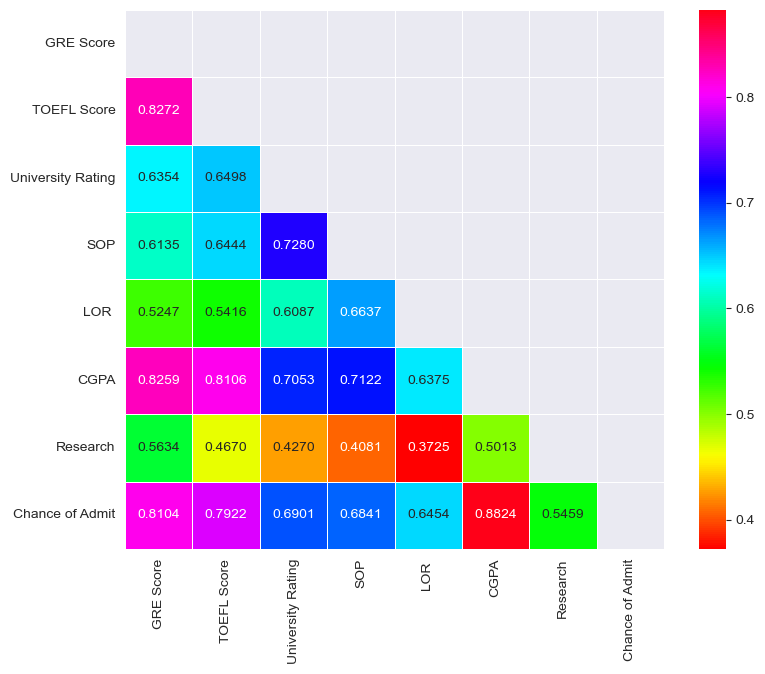

In [12]:
corr = cols.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("dark"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(corr,mask=mask,square=True,annot=True,fmt='0.4f',linewidths=.4,cmap="hsv")

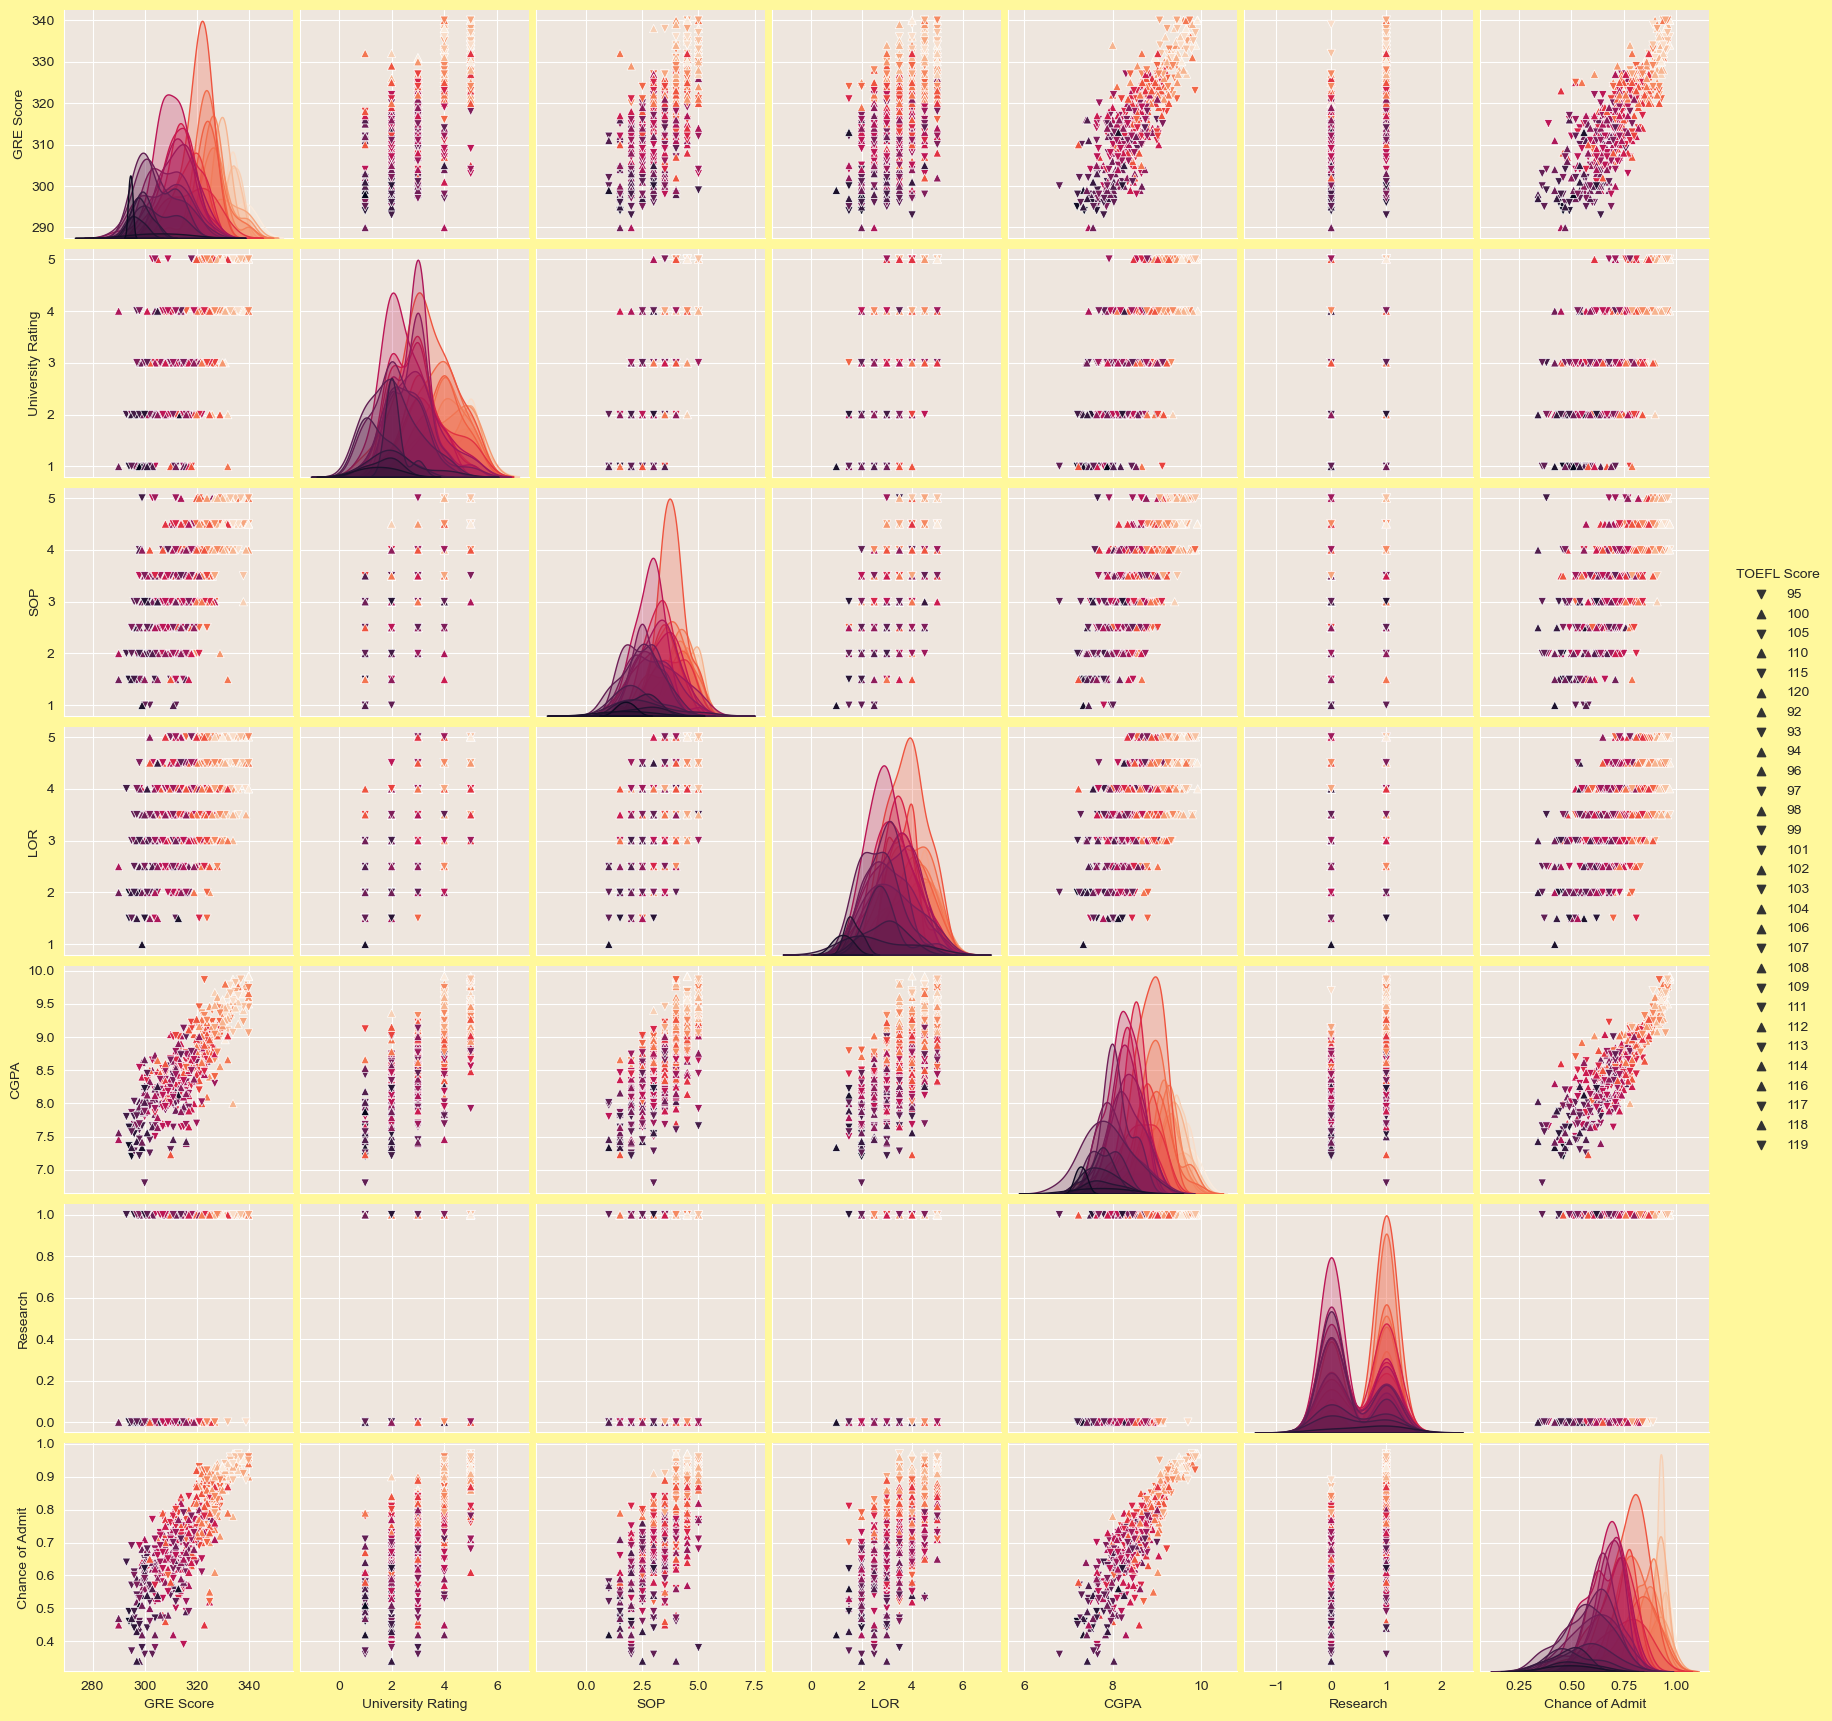

In [13]:
plt.rcParams['axes.facecolor'] = "#eee6de"
plt.rcParams['figure.facecolor'] = "#fff89c"
g = sns.pairplot(data=cols,hue='TOEFL Score',markers=["^", "v"],palette='rocket')

<Axes: xlabel='TOEFL Score', ylabel='Density'>

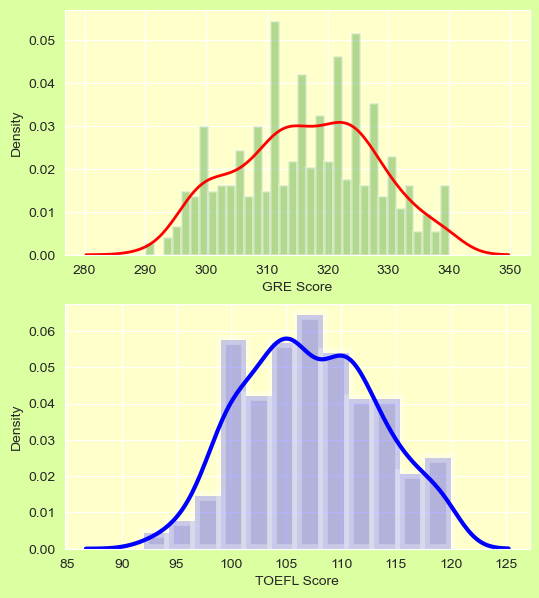

In [14]:
plt.rcParams['axes.facecolor'] = "#ffffcc"
plt.rcParams['figure.facecolor'] = "#dcffa1"
plt.figure(figsize=(6,7))
plt.subplot(2, 1, 1)
sns.distplot(df['GRE Score'],bins=34,color='Green',  kde_kws={"color": "r", "lw": 2, "label": "KDE"},hist_kws={"linewidth": 2,"alpha": 0.3 })
plt.subplot(2, 1, 2)
sns.distplot(df['TOEFL Score'],bins=12,color='Blue' ,kde_kws={"color": "b", "lw": 3, "label": "KDE"},hist_kws={"linewidth": 7,"alpha": 0.3 })

<Axes: xlabel='University Rating', ylabel='CGPA'>

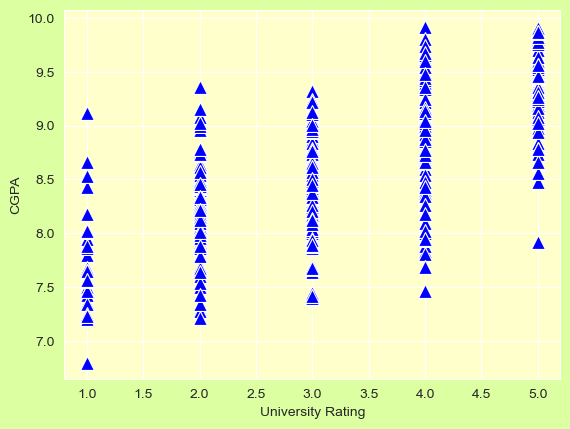

In [15]:
sns.scatterplot(x='University Rating',y='CGPA',data=df,color='Blue', marker="^", s=100)

In [16]:
co_gre=df[df["GRE Score"]>=300]
co_toefel=df[df["TOEFL Score"]>=100]

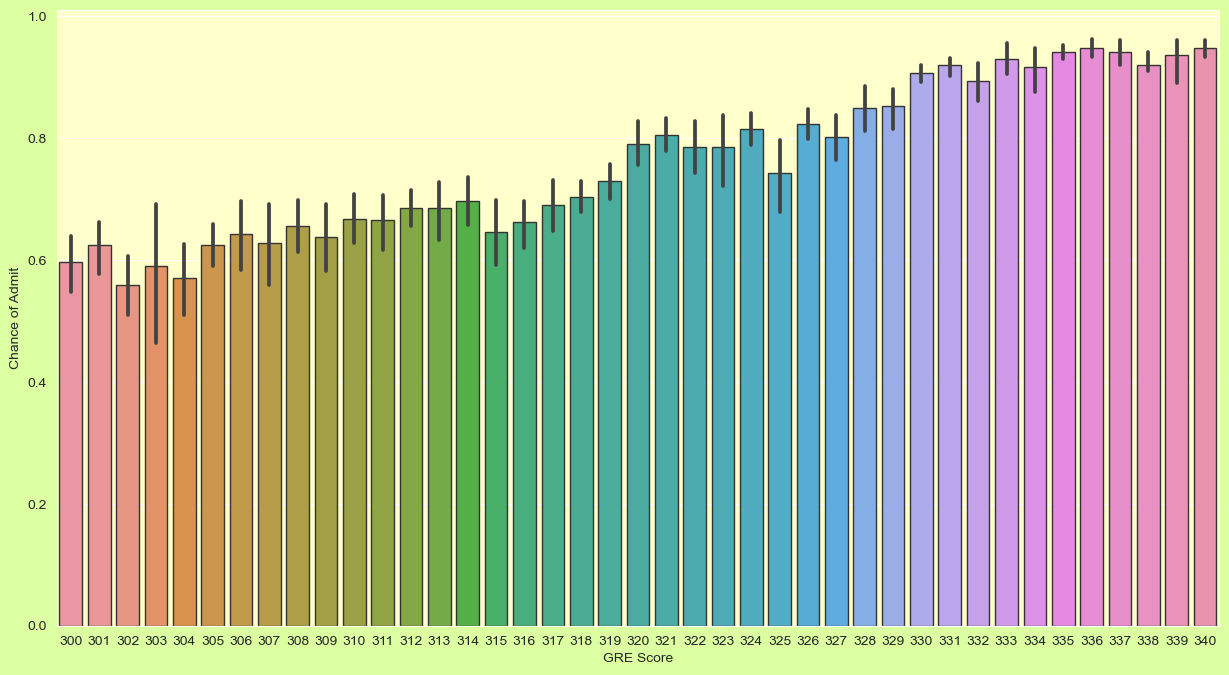

In [17]:
fig, ax = pyplot.subplots(figsize=(15,8))
sns.barplot(x='GRE Score',y='Chance of Admit',data=co_gre, linewidth=1.0,edgecolor="0.2")
plt.show()

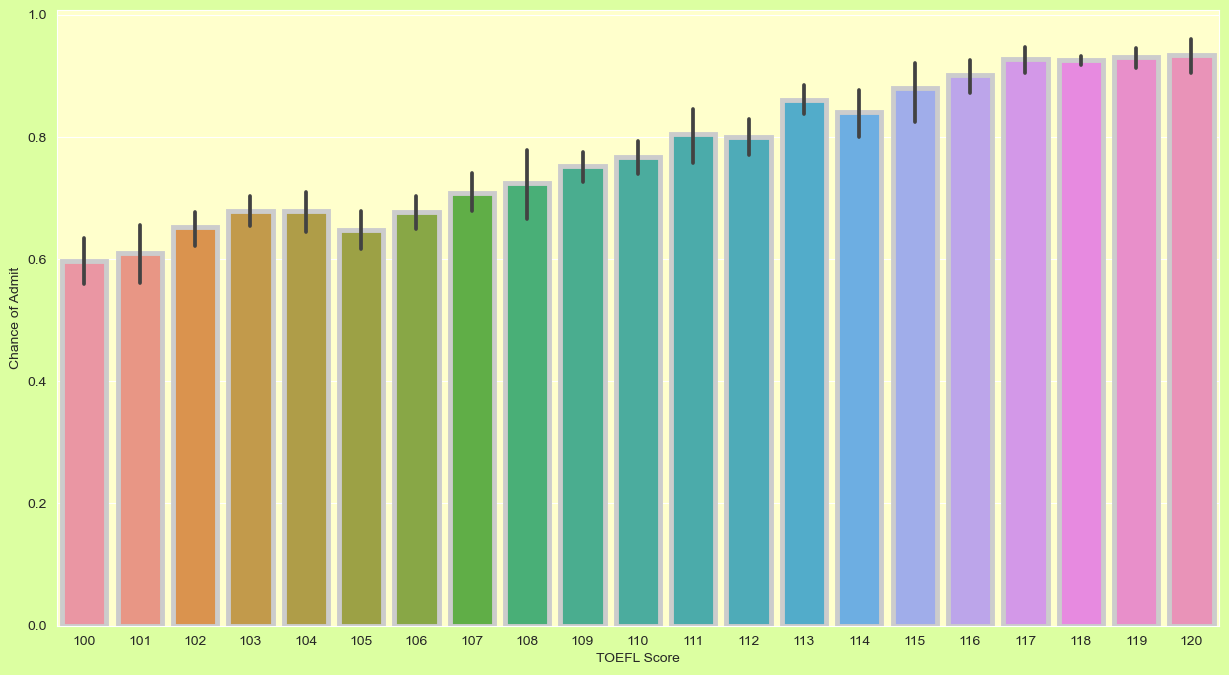

In [18]:
fig, ax = pyplot.subplots(figsize=(15,8))
sns.barplot(x='TOEFL Score',y='Chance of Admit',data=co_toefel, linewidth=3.5,edgecolor="0.8")
plt.show()

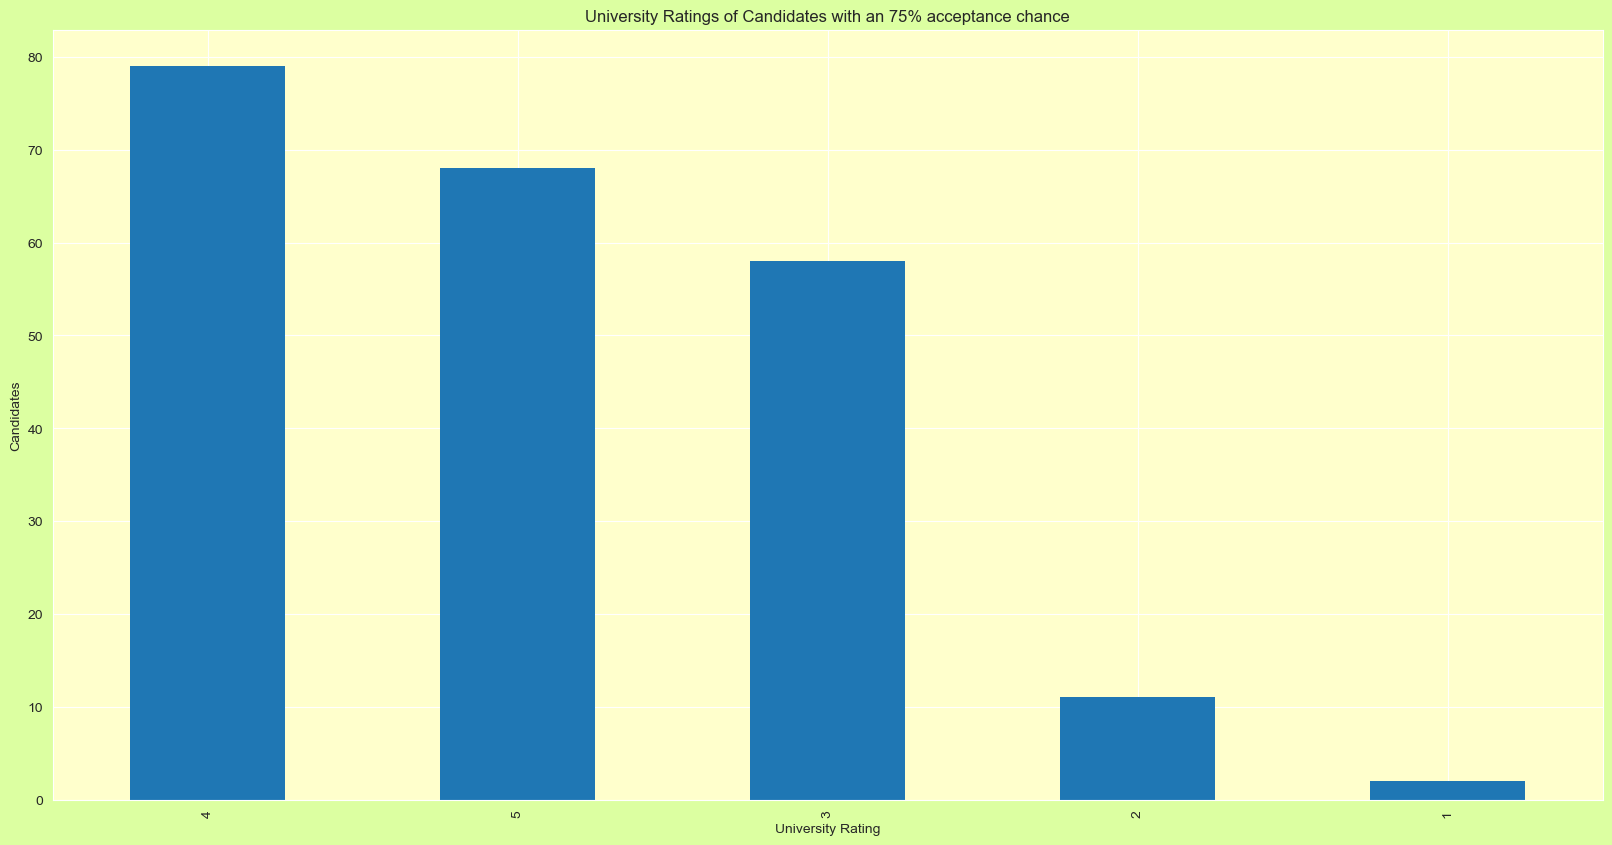

In [95]:
s = df[df["Chance of Admit"] >= 0.75]["University Rating"].value_counts().head(5)
plt.title("University Ratings of Candidates with an 75% acceptance chance")
s.plot(kind='bar',figsize=(20, 10),linestyle='',linewidth=5)
plt.xlabel("University Rating")
plt.ylabel("Candidates")
plt.show()

In [19]:
# reading the dataset
df = pd.read_csv("Admission_Predict.csv")

# it may be needed in the future.
serialNo = df["Serial No."].values

df.drop(["Serial No."],axis=1,inplace = True)

df=df.rename(columns = {'Chance of Admit ':'Chance of Admit'})

In [20]:
X=df.drop('Chance of Admit',axis=1)
y=df['Chance of Admit']

In [21]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Normalisation works slightly better for Regression.
X_norm=preprocessing.normalize(X)
X_train,X_test,y_train,y_test=train_test_split(X_norm,y,test_size=0.20,random_state=101)

In [28]:
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.ensemble import AdaBoostRegressor,AdaBoostClassifier
from sklearn.ensemble import ExtraTreesRegressor,ExtraTreesClassifier
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.svm import SVR,SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score,mean_squared_error

In [36]:
regressors=[['Linear Regression :',LinearRegression()],
       ['Decision Tree Regression :',DecisionTreeRegressor()],
       ['Random Forest Regression :',RandomForestRegressor()],          
       ['Extra Tree Regression :', ExtraTreesRegressor()],
       ['K-Neighbors Regression :',KNeighborsRegressor()],
       ['Support Vector Regression :',SVR()]]
reg_pred=[]
print('Results...\n')
for name,model in regressors:
    model=model
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    rms=np.sqrt(mean_squared_error(y_test, predictions))
    reg_pred.append(rms)
    print(name,rms)

Results...

Linear Regression : 0.07697452196086627
Decision Tree Regression : 0.10896100219803413
Random Forest Regression : 0.07468836171051017
Extra Tree Regression : 0.07709189646130132
K-Neighbors Regression : 0.09130553104823387
Support Vector Regression : 0.13567695865096108


In [41]:
y_ax=['Linear Regression' ,'Decision Tree Regression', 'Random Forest Regression','Extra Tree Regression' ,'K-Neighbors Regression', 'Support Vector Regression' ]
x_ax=reg_pred

<Axes: >

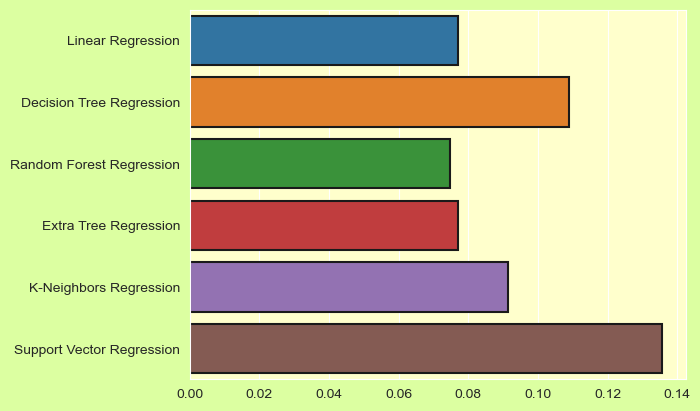

In [43]:
sns.barplot(x=x_ax,y=y_ax,linewidth=1.5,edgecolor="0.1")